In [1]:
# Load in our libraries
import pandas as pd
import numpy as np
import re
import sklearn
import xgboost as xgb
import matplotlib.pyplot as plt# Load in our libraries
import os
from sklearn.ensemble import (RandomForestClassifier, AdaBoostClassifier, 
                              GradientBoostingClassifier, ExtraTreesClassifier)
from sklearn.svm import SVC
from sklearn.model_selection import KFold

In [2]:
train = pd.read_csv('./train-new.csv')
test = pd.read_csv('./test-new.csv')

In [3]:
train.head(3)

,Unnamed: 0,encounter_id,hospital_id,hospital_death,age,bmi,elective_surgery,ethnicity,gender,height,...,d1_arterial_po2_min,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,apache_3j_bodysystem,apache_2_bodysystem,gcs_total,cancer,liver_disease,other
0,1,66154,118,0,68,3.123686,0,Caucasian,M,180.3,...,85.0,0.10,0.05,0,Sepsis,Cardiovascular,13,0,0,1
1,2,114252,81,0,77,3.311273,0,Caucasian,F,160.0,...,51.0,0.47,0.29,0,Respiratory,Respiratory,5,0,0,1
2,3,119783,118,0,25,3.464172,0,Caucasian,F,172.7,...,85.0,0.00,0.00,0,Metabolic,Metabolic,14,0,0,0


In [4]:
def dummies(train, test):
    columns = ['ethnicity', 'gender','icu_stay_type', 'hospital_admit_source', 
               'icu_admit_source', 'icu_type', 'apache_3j_bodysystem', 'apache_2_bodysystem', 
               'cancer', 'liver_disease', 'other']
    for column in columns:
        train[column] = train[column].apply(lambda x: str(x))
        test[column] = test[column].apply(lambda x: str(x))
        good_cols = [column+'_'+i for i in train[column].unique() if i in test[column].unique()]
        train = pd.concat((train, pd.get_dummies(train[column], prefix = column)[good_cols]), axis = 1)
        test = pd.concat((test, pd.get_dummies(test[column], prefix = column)[good_cols]), axis = 1)
        del train[column]
        del test[column]
    return train, test

In [5]:
train, test = dummies(train, test)

In [6]:
train.head(2)
train = train.rename(columns={"Unnamed: 0":"U0"})
train.shape

(91713, 179)

### Light GB

In [7]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
clf = lgb.LGBMClassifier(silent=True, random_state = 304, metric='roc_auc', n_jobs=4)

In [8]:
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

params ={'max_bin' : sp_randint(1, 2000),
         'max_depth': [2,3,4,5,6,7,8,9,10,11,12],
         'num_leaves': sp_randint(6, 2000)
        }

In [9]:
from sklearn.model_selection import train_test_split
X = train.loc[:, train.columns != 'hospital_death']
#X = X.loc[:, X.columns != 'encounter ID']              
Y = train.loc[:, train.columns == 'hospital_death']
Xtrain, Xval, Ytrain, Yval = train_test_split(X, Y, test_size = 0.25, random_state = 42)
print(Xval.shape)

(22929, 178)


In [10]:
fit_params={"early_stopping_rounds":3, 
            "eval_metric" : 'auc', 
            "eval_set" : [(Xtrain, Ytrain),(Xval,Yval)],
            'eval_names': ['train','valid'],
            'verbose': 300,
            'categorical_feature': 'auto'}

In [11]:
gs1 = RandomizedSearchCV(
    estimator=clf, param_distributions=params, 
    scoring='roc_auc',
    cv=10,
    refit=True,
    random_state=304,
    verbose=True)

In [12]:
gs1.fit(Xtrain, Ytrain, **fit_params)
print('Best score reached: {} with params: {} '.format(gs1.best_score_, gs1.best_params_))

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[61]	train's auc: 0.991253	valid's auc: 0.89394


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[50]	train's auc: 0.991085	valid's auc: 0.892472


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[70]	train's auc: 0.991551	valid's auc: 0.894925


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[60]	train's auc: 0.991338	valid's auc: 0.893268


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[55]	train's auc: 0.992487	valid's auc: 0.89511


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[54]	train's auc: 0.990854	valid's auc: 0.8935


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[80]	train's auc: 0.991578	valid's auc: 0.893194


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[54]	train's auc: 0.992391	valid's auc: 0.895553


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.991074	valid's auc: 0.894783


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[79]	train's auc: 0.992451	valid's auc: 0.894606


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.894309	valid's auc: 0.88732


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.89382	valid's auc: 0.888179


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.894191	valid's auc: 0.888534


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.894313	valid's auc: 0.888844


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.89444	valid's auc: 0.888123


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.893906	valid's auc: 0.888355


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.893901	valid's auc: 0.888179


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.893573	valid's auc: 0.887746


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.893213	valid's auc: 0.887501


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.894537	valid's auc: 0.88812


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[83]	train's auc: 0.991379	valid's auc: 0.895816


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	train's auc: 0.990415	valid's auc: 0.896767


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[69]	train's auc: 0.99121	valid's auc: 0.894569


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[87]	train's auc: 0.991677	valid's auc: 0.897189


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[46]	train's auc: 0.990444	valid's auc: 0.89099


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[69]	train's auc: 0.990735	valid's auc: 0.895392


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[58]	train's auc: 0.990378	valid's auc: 0.895263


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[84]	train's auc: 0.993497	valid's auc: 0.895122


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[69]	train's auc: 0.991428	valid's auc: 0.896351


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[66]	train's auc: 0.991867	valid's auc: 0.894911


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[65]	train's auc: 0.99083	valid's auc: 0.89426


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[53]	train's auc: 0.989827	valid's auc: 0.894984


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[64]	train's auc: 0.991198	valid's auc: 0.896167


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.991547	valid's auc: 0.89481


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[74]	train's auc: 0.992349	valid's auc: 0.895345


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[75]	train's auc: 0.991105	valid's auc: 0.894623


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[78]	train's auc: 0.991341	valid's auc: 0.895108


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[66]	train's auc: 0.992249	valid's auc: 0.896958


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.991483	valid's auc: 0.894529


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[67]	train's auc: 0.991561	valid's auc: 0.895184


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.97636	valid's auc: 0.896541


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[66]	train's auc: 0.976462	valid's auc: 0.897036


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[65]	train's auc: 0.976707	valid's auc: 0.897797


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[81]	train's auc: 0.979686	valid's auc: 0.898192


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[71]	train's auc: 0.979016	valid's auc: 0.897602


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.966868	valid's auc: 0.895562


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[65]	train's auc: 0.976456	valid's auc: 0.899113


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[82]	train's auc: 0.982271	valid's auc: 0.8988


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[60]	train's auc: 0.9738	valid's auc: 0.898463


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[83]	train's auc: 0.981149	valid's auc: 0.897501


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.99162	valid's auc: 0.894802


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[67]	train's auc: 0.990958	valid's auc: 0.893606


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[43]	train's auc: 0.989599	valid's auc: 0.893952


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[73]	train's auc: 0.991666	valid's auc: 0.896251


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[74]	train's auc: 0.992586	valid's auc: 0.894702


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[26]	train's auc: 0.983306	valid's auc: 0.890861


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[50]	train's auc: 0.990263	valid's auc: 0.894326


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[49]	train's auc: 0.992191	valid's auc: 0.893286


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[76]	train's auc: 0.991585	valid's auc: 0.895284


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[41]	train's auc: 0.98991	valid's auc: 0.891335


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921995	valid's auc: 0.897064


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921189	valid's auc: 0.897772


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921061	valid's auc: 0.896224


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921345	valid's auc: 0.896534


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.92122	valid's auc: 0.897871


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.920555	valid's auc: 0.896737


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.920903	valid's auc: 0.896406


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921025	valid's auc: 0.896931


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.920486	valid's auc: 0.896546


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.921347	valid's auc: 0.897556


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[96]	train's auc: 0.954937	valid's auc: 0.898866


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[91]	train's auc: 0.955233	valid's auc: 0.898747


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[68]	train's auc: 0.945353	valid's auc: 0.896579


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[63]	train's auc: 0.944253	valid's auc: 0.897331


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.957669	valid's auc: 0.898924


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.954845	valid's auc: 0.899497


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[91]	train's auc: 0.953685	valid's auc: 0.898109


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[71]	train's auc: 0.947912	valid's auc: 0.897945


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[79]	train's auc: 0.95	valid's auc: 0.899528


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.955564	valid's auc: 0.898826


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[76]	train's auc: 0.986246	valid's auc: 0.898722


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[75]	train's auc: 0.986879	valid's auc: 0.896733


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[54]	train's auc: 0.982585	valid's auc: 0.8965


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[65]	train's auc: 0.985252	valid's auc: 0.898173


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[39]	train's auc: 0.977371	valid's auc: 0.894587


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[59]	train's auc: 0.983507	valid's auc: 0.8971


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[91]	train's auc: 0.987968	valid's auc: 0.898183


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[60]	train's auc: 0.986406	valid's auc: 0.896208


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[57]	train's auc: 0.983166	valid's auc: 0.897642


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[59]	train's auc: 0.984121	valid's auc: 0.895937


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932978	valid's auc: 0.897598


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932102	valid's auc: 0.897752


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.931981	valid's auc: 0.899345


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932869	valid's auc: 0.898592


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932652	valid's auc: 0.897848


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932042	valid's auc: 0.898418


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[96]	train's auc: 0.931116	valid's auc: 0.898853


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[96]	train's auc: 0.931612	valid's auc: 0.898515


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932261	valid's auc: 0.899749


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	train's auc: 0.932652	valid's auc: 0.897215


[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 12.8min finished
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training until validation scores don't improve for 3 rounds
Early stopping, best iteration is:
[95]	train's auc: 0.958284	valid's auc: 0.898944
Best score reached: 0.8980895018967556 with params: {'max_bin': 1687, 'max_depth': 6, 'num_leaves': 1433} 


In [13]:
gs1.best_params_, gs1.best_score_

({'max_bin': 1687, 'max_depth': 6, 'num_leaves': 1433}, 0.8980895018967556)

In [14]:
clf2 = lgb.LGBMClassifier(random_state=304, metric = 'roc_auc', max_bin = 1687, max_depth = 6, num_leaves=1433, n_jobs=4)

In [15]:
params_2 ={'learning_rate': [0.08],
           'num_iterations' : [1005],
           'boosting' : ["dart"],
           'bagging_fraction': [0.4]
        }


In [16]:
gs2 = RandomizedSearchCV(
    estimator=clf2, param_distributions=params_2, 
    scoring='roc_auc',
    cv=10,
    refit=True,
    random_state=304,
    verbose=True)

In [17]:
gs2.fit(Xtrain, Ytrain, **fit_params)
print('Best score reached: {} with params: {} '.format(gs2.best_score_, gs2.best_params_))

C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\model_selection\_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\e

Fitting 10 folds for each of 1 candidates, totalling 10 fits


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available in dart mode')


[300]	train's auc: 0.952964	valid's auc: 0.898634
[600]	train's auc: 0.969706	valid's auc: 0.902007
[900]	train's auc: 0.980267	valid's auc: 0.902248


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.953162	valid's auc: 0.899411
[600]	train's auc: 0.970408	valid's auc: 0.901607
[900]	train's auc: 0.980505	valid's auc: 0.90197


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.952809	valid's auc: 0.8995
[600]	train's auc: 0.970577	valid's auc: 0.901922
[900]	train's auc: 0.980678	valid's auc: 0.901874


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.952401	valid's auc: 0.899275
[600]	train's auc: 0.97018	valid's auc: 0.902597
[900]	train's auc: 0.980501	valid's auc: 0.903826


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.953923	valid's auc: 0.89933
[600]	train's auc: 0.97132	valid's auc: 0.90262
[900]	train's auc: 0.981205	valid's auc: 0.901443


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.953806	valid's auc: 0.899181
[600]	train's auc: 0.970674	valid's auc: 0.902611
[900]	train's auc: 0.979868	valid's auc: 0.902824


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.952643	valid's auc: 0.899419
[600]	train's auc: 0.971171	valid's auc: 0.901334
[900]	train's auc: 0.980652	valid's auc: 0.901323


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.955374	valid's auc: 0.899506
[600]	train's auc: 0.9718	valid's auc: 0.902368
[900]	train's auc: 0.981414	valid's auc: 0.901905


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.952899	valid's auc: 0.900549
[600]	train's auc: 0.970791	valid's auc: 0.903291
[900]	train's auc: 0.980472	valid's auc: 0.902271


C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not available in dart mode
  warnings.warn('Early stopping is not available

[300]	train's auc: 0.953426	valid's auc: 0.898704
[600]	train's auc: 0.970853	valid's auc: 0.900924
[900]	train's auc: 0.981302	valid's auc: 0.901116


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 19.9min finished
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\callback.py:188: UserWarning: Early stopping is not a

[300]	train's auc: 0.956368	valid's auc: 0.899145
[600]	train's auc: 0.975461	valid's auc: 0.902669
[900]	train's auc: 0.98664	valid's auc: 0.902707
Best score reached: 0.9026242986605971 with params: {'num_iterations': 1005, 'learning_rate': 0.08, 'boosting': 'dart', 'bagging_fraction': 0.4} 


In [18]:
gs2.best_params_, gs2.best_score_

({'num_iterations': 1005,
  'learning_rate': 0.08,
  'boosting': 'dart',
  'bagging_fraction': 0.4},
 0.9026242986605971)

In [19]:
gs2.best_params_.update({'scoring':'roc_auc', 'metric':'auc', 'objective': 'binary'})
gs2.best_params_

{'num_iterations': 1005,
 'learning_rate': 0.08,
 'boosting': 'dart',
 'bagging_fraction': 0.4,
 'scoring': 'roc_auc',
 'metric': 'auc',
 'objective': 'binary'}

In [20]:
lgbm_train2 = lgb.Dataset(Xtrain, Ytrain)
# lgbm_test = lgbm.Dataset(X_test, y_test, categorical_feature=cat_cols)
lgbm_val2 = lgb.Dataset(Xval, Yval, reference = lgbm_train2)


In [21]:
evals_result = {}  # to record eval results for plotting
model_lgbm_2 = lgb.train(gs2.best_params_,
                lgbm_train2,
                num_boost_round=250,
                valid_sets=[lgbm_train2, lgbm_val2],
                feature_name=['f' + str(i + 1) for i in range(Xtrain.shape[-1])],
                categorical_feature= [182],
                evals_result=evals_result,
                verbose_eval=100)

C:\Users\anany\Anaconda3\envs\envTF113\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is [182]
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[100]	training's auc: 0.920379	valid_1's auc: 0.891772
[200]	training's auc: 0.931693	valid_1's auc: 0.89546
[300]	training's auc: 0.947551	valid_1's auc: 0.899104
[400]	training's auc: 0.958527	valid_1's auc: 0.900921
[500]	training's auc: 0.969203	valid_1's auc: 0.902105
[600]	training's auc: 0.974118	valid_1's auc: 0.903106
[700]	training's auc: 0.979446	valid_1's auc: 0.90323
[800]	training's auc: 0.983204	valid_1's auc: 0.903428
[900]	training's auc: 0.986893	valid_1's auc: 0.903735
[1000]	training's auc: 0.989789	valid_1's auc: 0.903935


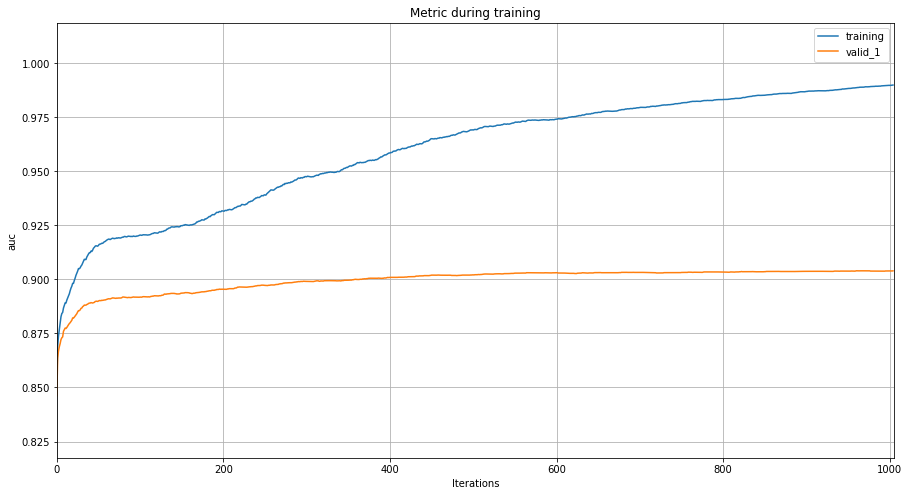

In [22]:
ax = lgb.plot_metric(evals_result, metric='auc', figsize=(15, 8))
plt.show()

In [23]:
test["hospital_death"] = model_lgbm_2.predict(test.loc[:, test.columns != 'hospital_death'], pred_contrib=False)


In [24]:
test[["encounter_id","hospital_death"]].to_csv("submission_lgbm_2.csv",index=False)
test[["encounter_id","hospital_death"]].head()

,encounter_id,hospital_death
0,2,0.015061
1,5,0.024314
2,7,0.005924
3,8,0.181263
4,10,0.677184
